In [7]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [23]:
def BS_delta(CP,S_0,K,sigma,t,T,r):
    #K = np.array(K).reshape([len(K),1])
    #K=K[0]
    
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * (T-t)) / (sigma * np.sqrt(T-t))
    if CP == 'call':
        value = norm.cdf(d1)
        
    elif CP == 'put':
       value = norm.cdf(d1)-1
    return value

def GeneratePathsGBM(NoOfPaths, NoOfSteps, T, r, sigma, S_0):  
    
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])  # números aleatorios estándar
    X = np.zeros([NoOfPaths, NoOfSteps + 1])
    W = np.zeros([NoOfPaths, NoOfSteps + 1])
    time = np.zeros([NoOfSteps + 1])
        
    X[:, 0] = np.log(S_0)  # log del precio inicial
    
    dt = T / float(NoOfSteps)  # tamaño del paso temporal
    
    for i in range(0, NoOfSteps):
        # Normalizar Z para que tenga media 0 y varianza 1 en cada paso
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        
        W[:, i+1] = W[:, i] + np.sqrt(dt) * Z[:, i]  # camino de Wiener
        X[:, i+1] = X[:, i] + (r - 0.5 * sigma**2) * dt + sigma * (W[:, i+1] - W[:, i])
        time[i+1] = time[i] + dt
        
    S = np.exp(X)  # precios del activo en cada tiempo y simulación
    paths = {"time": time, "S": S}
    
    return paths

In [24]:
def PathwiseDelta(CP, S0, S, K, r, T):
    ST = S[:, -1]   # valores finales del activo
    K=K[0]
    if CP == 'call':
        indicator = (ST > K).astype(float)
        delta = np.exp(-r*T) * np.mean((ST / S0) * indicator)

    elif CP == 'put':
        indicator = (ST < K).astype(float)
        delta = -np.exp(-r*T) * np.mean((ST / S0) * indicator)

    return delta


In [3]:
### aqui tengo otra funcion por si K no fuese solo un valor, si tuviera diferentes K
def PathwiseDelta_k(CP, S0, S, K, r, T):

    ST = S[:, -1]
    deltas = []

    for k in K:
    
        if CP == 'call':
            indicator = (ST > k).astype(float)
            delta_k = np.exp(-r*T) * np.mean((ST / S0) * indicator)

        elif CP == 'put':
            indicator = (ST < k).astype(float)
            delta_k = -np.exp(-r*T) * np.mean((ST / S0) * indicator)

        deltas.append(delta_k)

    return np.array(deltas).reshape(len(K),1)

In [25]:
CP        = 'call'
S0        = 1.0
r         = 0.06
sigma     = 0.3
T         = 1.0
K         = np.array([S0])
t         = 0.0

NoOfSteps = 1000

In [28]:

delta_Exact = BS_delta(CP, S0, K, sigma, t, T, r)
    
# diferentes números de caminos para ver convergencia
NoOfPathsV = np.round(np.linspace(5, 20000, 50))
deltaPathWiseV = np.zeros(len(NoOfPathsV))

Running simulation with 5 paths
Running simulation with 413 paths
Running simulation with 821 paths
Running simulation with 1229 paths
Running simulation with 1637 paths
Running simulation with 2045 paths
Running simulation with 2453 paths
Running simulation with 2861 paths
Running simulation with 3269 paths
Running simulation with 3678 paths
Running simulation with 4086 paths
Running simulation with 4494 paths
Running simulation with 4902 paths
Running simulation with 5310 paths
Running simulation with 5718 paths
Running simulation with 6126 paths
Running simulation with 6534 paths
Running simulation with 6942 paths
Running simulation with 7350 paths
Running simulation with 7758 paths
Running simulation with 8166 paths
Running simulation with 8574 paths
Running simulation with 8982 paths
Running simulation with 9390 paths
Running simulation with 9798 paths
Running simulation with 10207 paths
Running simulation with 10615 paths
Running simulation with 11023 paths
Running simulation wit

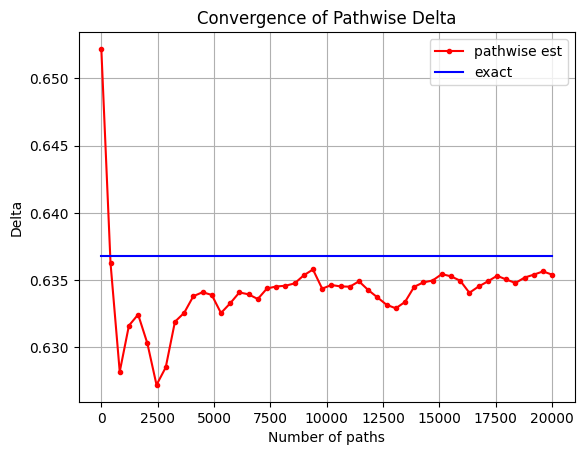

In [30]:
for idx, nPaths in enumerate(NoOfPathsV):
    print(f'Running simulation with {int(nPaths)} paths')
    np.random.seed(3)  # semilla
    
    paths = GeneratePathsGBM(int(nPaths), NoOfSteps, T, r, sigma, S0)
    S = paths["S"]
    delta_pathwise = PathwiseDelta(CP, S0, S, K, r, T)
    deltaPathWiseV[idx] = delta_pathwise
    
  
plt.figure()
plt.grid()
plt.plot(NoOfPathsV, deltaPathWiseV, '.-r', label='pathwise est')
plt.plot(NoOfPathsV, delta_Exact*np.ones(len(NoOfPathsV)), 'b', label='exact')
plt.xlabel('Number of paths')
plt.ylabel('Delta')
plt.title('Convergence of Pathwise Delta')
plt.legend()
plt.show()

DELTA PATHWISE:
- Toma el precio final S_T

- Para call: 1{S_T > K} * S_T/S0 * e^{-rT} (Para put: similar pero negativo)

- Promediamos sobre todas las trayectorias → estimador Monte Carlo

**INTERPRETACIÓN GRAFICA**
- X (Number of paths): número de caminos simulados en Monte Carlo. Desde 5 hasta 20000.
- Y (Delta): valor del estimador de Delta de la opción.

Análisis:
- Con pocos caminos (≈5–1000): la línea roja se aleja del valor exacto porque Monte Carlo con pocas trayectorias tiene más varianza.
- A medida que aumenta el número de caminos (>5000–10000): la línea roja se empieza a acercar (“converger”) hacia el valor exacto.

    El estimador se estabiliza cerca de 0.6367.

Conclusión:

El método pathwise es consistente: a medida que el número de caminos crece, converge al valor exacto.

La varianza disminuye con más simulaciones → mejor estimación.

Incluso con 20 000 caminos, aún hay un poco de fluctuación 

(?) El gráfico muestra visualmente la ley de los grandes números: al aumentar el número de caminos, la media de las simulaciones se acerca al valor esperado exacto.